In [57]:
# 导库 获取数据
import numpy as np
import pandas as pd 
from sklearn.linear_model import LogisticRegression as LR 

In [58]:
data=pd.read_csv("rankingcard.csv",index_col=0)

In [59]:
data.shape

(150000, 11)

In [60]:
# 1.去除重复值
data.drop_duplicates(inplace=True)
data.index=range(data.shape[0])

In [61]:
data.shape

(149391, 11)

In [62]:
# 2.填补缺失值
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
SeriousDlqin2yrs                        149391 non-null int64
RevolvingUtilizationOfUnsecuredLines    149391 non-null float64
age                                     149391 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    149391 non-null int64
DebtRatio                               149391 non-null float64
MonthlyIncome                           120170 non-null float64
NumberOfOpenCreditLinesAndLoans         149391 non-null int64
NumberOfTimes90DaysLate                 149391 non-null int64
NumberRealEstateLoansOrLines            149391 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    149391 non-null int64
NumberOfDependents                      145563 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.5 MB


In [70]:
#可以观察缺失值NumberOfDependents和MonthlyIncome   
#家属人数缺失值很少，可以删除或者用均值去取整来代替
data["NumberOfDependents"].fillna(int(data["NumberOfDependents"].mean()),inplace=True)

In [74]:
# 对于收入来说，收入是一个对信用评分来说很重要的因素，因此这个因素必须进行填补
# 这里采用随机森林的方式对MonthlyIncome空值进行填补
def fill__missing_rfr(x,y,to_fill):
    """
    X：要填补的特征矩阵
   y：完整的，没有缺失值的标签
   to_fill：字符串，要填补的那一列的名称
    """
    df=x.copy()
    fill=df.loc[:,to_fill]
    df=pd.concat([df.loc[:,df.columns!=to_fill],pd.DataFrame(y)],axis=1)
    
    #找出训练集和测试集
    ytrain=fill[fill.notnull()]
    ytest=fill[fill.isnull()]
    xtrain=df.iloc[ytrain.index,:]
    xtest=df.iloc[ytest.index,:]
    
    #用随机森林回归来填补缺失值
    from sklearn.ensemble import RandomForestRegressor as rfr
    rfr=rfr(n_estimators=100)
    rfr=rfr.fit(xtrain,ytrain)
    ypredict=rfr.predict(xtest)
    
    return ypredict
    

In [75]:
# 创造函数参数，将参数导入函数，产出结果 
x=data.iloc[:,1:]
y=data["SeriousDlqin2yrs"]
x.shape

(149391, 10)

In [76]:
#=====[TIME WARNING:1 min]=====#
y_pred=fill__missing_rfr(x,y,"MonthlyIncome")

In [77]:
data.loc[data.loc[:,"MonthlyIncome"].isnull(),"MonthlyIncome"]=y_pred

In [78]:
#描述性统计
# data.describe()
data.describe([0.01,0.1,0.25,.5,.75,.9,.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
SeriousDlqin2yrs,149391.0,0.066999,0.250021,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
RevolvingUtilizationOfUnsecuredLines,149391.0,6.071087,250.263672,0.0,0.0,0.003199,0.030132,0.154235,0.556494,0.978007,1.093922,50708.0
age,149391.0,52.306237,14.725962,0.0,24.0,33.000000,41.000000,52.000000,63.000000,72.000000,87.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,149391.0,0.393886,3.852953,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,98.0
DebtRatio,149391.0,354.436740,2041.843455,0.0,0.0,0.034991,0.177441,0.368234,0.875279,1275.000000,4985.100000,329664.0
MonthlyIncome,149391.0,5422.349424,13234.290423,0.0,0.0,0.170000,1800.000000,4417.000000,7416.000000,10800.000000,23250.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,149391.0,8.480892,5.136515,0.0,0.0,3.000000,5.000000,8.000000,11.000000,15.000000,24.000000,58.0
NumberOfTimes90DaysLate,149391.0,0.238120,3.826165,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,98.0
NumberRealEstateLoansOrLines,149391.0,1.022391,1.130196,0.0,0.0,0.000000,0.000000,1.000000,2.000000,2.000000,4.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,149391.0,0.212503,3.810523,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,98.0


In [79]:
# 3.去除异常值
# 异常值一般被我们观察到，年龄值最小值居然是0，这不符合银行的业务需求
(data["age"]==0).sum()

1

In [80]:
# 发现只有一个人年龄为0，可以判断这是录入失误造成的，可以当成是缺失值来处理
data=data[data["age"]!=0]

In [81]:
[data.min(),data.max()]

[SeriousDlqin2yrs                         0.0
 RevolvingUtilizationOfUnsecuredLines     0.0
 age                                     21.0
 NumberOfTime30-59DaysPastDueNotWorse     0.0
 DebtRatio                                0.0
 MonthlyIncome                            0.0
 NumberOfOpenCreditLinesAndLoans          0.0
 NumberOfTimes90DaysLate                  0.0
 NumberRealEstateLoansOrLines             0.0
 NumberOfTime60-89DaysPastDueNotWorse     0.0
 NumberOfDependents                       0.0
 dtype: float64, SeriousDlqin2yrs                              1.0
 RevolvingUtilizationOfUnsecuredLines      50708.0
 age                                         109.0
 NumberOfTime30-59DaysPastDueNotWorse         98.0
 DebtRatio                                329664.0
 MonthlyIncome                           3008750.0
 NumberOfOpenCreditLinesAndLoans              58.0
 NumberOfTimes90DaysLate                      98.0
 NumberRealEstateLoansOrLines                 54.0
 NumberOfTime60-89D

In [82]:
# 可以发现预期不应该超过90 ，可是存在最大值98这样的异常值
data.loc[data.loc[:,"NumberOfTimes90DaysLate"]>90,"NumberOfTimes90DaysLate"].count()

225

In [83]:
# 删除这些异常值
data=data[data.loc[:,"NumberOfTimes90DaysLate"]<90]

In [84]:
data.index=range(data.shape[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149165 entries, 0 to 149164
Data columns (total 11 columns):
SeriousDlqin2yrs                        149165 non-null int64
RevolvingUtilizationOfUnsecuredLines    149165 non-null float64
age                                     149165 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    149165 non-null int64
DebtRatio                               149165 non-null float64
MonthlyIncome                           149165 non-null float64
NumberOfOpenCreditLinesAndLoans         149165 non-null int64
NumberOfTimes90DaysLate                 149165 non-null int64
NumberRealEstateLoansOrLines            149165 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    149165 non-null int64
NumberOfDependents                      149165 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.5 MB


In [85]:
# 4.这里不统一量纲 也不标准化数据分布 因为最终目的是给业务人员
# 5.样本不均衡问题 

x=data.iloc[:,1:]
y=data.iloc[:,0]
y.value_counts()

n_sample=x.shape[0]
n_1_sample=y.value_counts()[1]
n_0_sample=y.value_counts()[0]

print("样本数：{};1占{:.2%};0占{:.2%}".format(n_sample,n_1_sample/n_sample,n_0_sample/n_sample))

样本数：149165;1占6.62%;0占93.38%


In [86]:
# 样本严重不平衡
# 但是我们通常需要捕捉少违约的人数
import imblearn
from imblearn.over_sampling import SMOTE

sm=SMOTE(random_state=42)
x,y=sm.fit_sample(x,y)

n_sample_=x.shape[0]
#这里[0]、[1]表示index
n_1_sample=pd.Series(y).value_counts()[1]
n_0_sample=pd.Series(y).value_counts()[0]

print('样本个数:{},1占{:.2%};0占{:.2%}'.format(n_sample_,n_1_sample/n_sample_,n_0_sample/n_sample_))


样本个数:278584,1占50.00%;0占50.00%


In [88]:
# 6.分训练集和测试集
from sklearn.model_selection import train_test_split
x=pd.DataFrame(x)
y=pd.DataFrame(y)

x_train,x_vali,y_train,y_vali=train_test_split(x,y,test_size=0.3,random_state=420)
model_data=pd.concat([y_train,x_train],axis=1)
model_data.index=range(model_data.shape[0])
#model_data.columns=data.columns

vali_data=pd.concat([y_vali,x_vali],axis=1)
vali_data.index=range(vali_data.shape[0])
#vali_data.columns=data.columns

model_data.to_csv("model_data.csv")
vali_data.to_csv("vali_data.csv")

In [89]:
# 7.分箱
# 返回qcut分箱范围、updown为分箱的边界值
model_data["qcut"],updown=pd.qcut(model_data["age"],retbins=True,q=20)

In [92]:
model_data["qcut"]

0         (52.0, 54.0]
1         (61.0, 64.0]
2         (36.0, 39.0]
3         (68.0, 74.0]
4         (52.0, 54.0]
              ...     
195003    (31.0, 34.0]
195004    (48.0, 50.0]
195005    (45.0, 46.0]
195006    (61.0, 64.0]
195007    (52.0, 54.0]
Name: qcut, Length: 195008, dtype: category
Categories (20, interval[float64]): [(20.999, 28.0] < (28.0, 31.0] < (31.0, 34.0] < (34.0, 36.0] ... (61.0, 64.0] < (64.0, 68.0] < (68.0, 74.0] < (74.0, 107.0]]

In [93]:
updown

array([ 21.,  28.,  31.,  34.,  36.,  39.,  41.,  43.,  45.,  46.,  48.,
        50.,  52.,  54.,  56.,  58.,  61.,  64.,  68.,  74., 107.])

In [96]:
model_data.shape

(195008, 12)

In [100]:
# 统计每个分箱中0和1的个数
# 这里使用了数据透视表的功能groupby
coount_y0=model_data[model_data["SeriousDlqin2yrs"]==0].groupby("qcut").count()["SeriousDlqin2yrs"]
coount_y1=model_data[model_data["SeriousDlqin2yrs"]==1].groupby("qcut").count()["SeriousDlqin2yrs"]

In [102]:
coount_y0,coount_y1

(qcut
 (20.999, 28.0]    4243
 (28.0, 31.0]      3571
 (31.0, 34.0]      4075
 (34.0, 36.0]      2908
 (36.0, 39.0]      5182
 (39.0, 41.0]      3956
 (41.0, 43.0]      4002
 (43.0, 45.0]      4389
 (45.0, 46.0]      2419
 (46.0, 48.0]      4813
 (48.0, 50.0]      4900
 (50.0, 52.0]      4728
 (52.0, 54.0]      4681
 (54.0, 56.0]      4677
 (56.0, 58.0]      4483
 (58.0, 61.0]      6583
 (61.0, 64.0]      6968
 (64.0, 68.0]      6623
 (68.0, 74.0]      6753
 (74.0, 107.0]     7737
 Name: SeriousDlqin2yrs, dtype: int64, qcut
 (20.999, 28.0]    7552
 (28.0, 31.0]      5945
 (31.0, 34.0]      6821
 (34.0, 36.0]      4586
 (36.0, 39.0]      7446
 (39.0, 41.0]      5836
 (41.0, 43.0]      5697
 (43.0, 45.0]      5953
 (45.0, 46.0]      3268
 (46.0, 48.0]      6160
 (48.0, 50.0]      6222
 (50.0, 52.0]      5805
 (52.0, 54.0]      5014
 (54.0, 56.0]      4025
 (56.0, 58.0]      3406
 (58.0, 61.0]      4829
 (61.0, 64.0]      3196
 (64.0, 68.0]      2273
 (68.0, 74.0]      1915
 (74.0, 107.0]

In [103]:
num_bins=[*zip(updown,updown[1:],coount_y0,coount_y1)]

In [104]:
num_bins

[(21.0, 28.0, 4243, 7552),
 (28.0, 31.0, 3571, 5945),
 (31.0, 34.0, 4075, 6821),
 (34.0, 36.0, 2908, 4586),
 (36.0, 39.0, 5182, 7446),
 (39.0, 41.0, 3956, 5836),
 (41.0, 43.0, 4002, 5697),
 (43.0, 45.0, 4389, 5953),
 (45.0, 46.0, 2419, 3268),
 (46.0, 48.0, 4813, 6160),
 (48.0, 50.0, 4900, 6222),
 (50.0, 52.0, 4728, 5805),
 (52.0, 54.0, 4681, 5014),
 (54.0, 56.0, 4677, 4025),
 (56.0, 58.0, 4483, 3406),
 (58.0, 61.0, 6583, 4829),
 (61.0, 64.0, 6968, 3196),
 (64.0, 68.0, 6623, 2273),
 (68.0, 74.0, 6753, 1915),
 (74.0, 107.0, 7737, 1368)]

In [107]:
for i in range(20):
    #如果第一个组没有包含正样本或负样本，向后合并
    if 0 in num_bins[0][2:]:
        num_bins[0:2] = [(
            num_bins[0][0],
            num_bins[1][1],
            num_bins[0][2]+num_bins[1][2],
            num_bins[0][3]+num_bins[1][3])]
        continue
    for i in range(len(num_bins)):
        if 0 in num_bins[i][2:]:
            num_bins[i-1:i+1] = [(
                num_bins[i-1][0],
                num_bins[i][1],
                num_bins[i-1][2]+num_bins[i][2],
                num_bins[i-1][3]+num_bins[i][3])]
        break
        #如果对第一组和对后面所有组的判断中，都没有进入if去合并，则提前结束所有的循环
    else:
        break

In [108]:
# 定义WOE和IV函数
def get_woe(num_bins):
    columns=["min","max","count_0","count_1"]
    df=pd.DataFrame(num_bins,columns=columns)
    
    df["total"]=df.count_0+df.count_1
    df["percentage"]=df.total/df.total.sum()
    df["bad_rate"]=df.count_0/df.total
    df["good%"]=df.count_0/df.count_0.sum()
    df["bad%"]=df.count_1/df.count_1.sum()
    df["woe"]=np.log(df["good%"]/df["bad%"])
    return df

def get_iv(df):
    rate=df["good%"]-df["bad%"]
    iv=np.sum(rate*df.woe)
    return iv

In [110]:
num_bins

[(21.0, 28.0, 4243, 7552),
 (28.0, 31.0, 3571, 5945),
 (31.0, 34.0, 4075, 6821),
 (34.0, 36.0, 2908, 4586),
 (36.0, 39.0, 5182, 7446),
 (39.0, 41.0, 3956, 5836),
 (41.0, 43.0, 4002, 5697),
 (43.0, 45.0, 4389, 5953),
 (45.0, 46.0, 2419, 3268),
 (46.0, 48.0, 4813, 6160),
 (48.0, 50.0, 4900, 6222),
 (50.0, 52.0, 4728, 5805),
 (52.0, 54.0, 4681, 5014),
 (54.0, 56.0, 4677, 4025),
 (56.0, 58.0, 4483, 3406),
 (58.0, 61.0, 6583, 4829),
 (61.0, 64.0, 6968, 3196),
 (64.0, 68.0, 6623, 2273),
 (68.0, 74.0, 6753, 1915),
 (74.0, 107.0, 7737, 1368)]

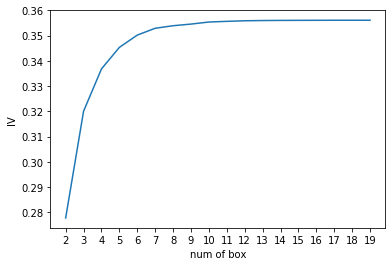

In [112]:
num_bins_=num_bins.copy()

import matplotlib.pyplot as plt
import scipy

IV=[]
axisx=[]

while len(num_bins_)>2:
    pvs=[]
    # 邻邻相比
    for i in range(len(num_bins_)-1):
        x1=num_bins_[i][2:]
        x2=num_bins_[i+1][2:]
        pv=scipy.stats.chi2_contingency([x1,x2])[1]
        pvs.append(pv)
    
    i=pvs.index(max(pvs))
    num_bins_[i:i+2]=[(num_bins_[i][0],
                    num_bins_[i+1][1],
                      num_bins_[i][2]+num_bins_[i+1][2],
                      num_bins_[i][3]+num_bins_[i+1][3])]
    bins_df=get_woe(num_bins_)
    axisx.append(len(num_bins_))
    IV.append(get_iv(bins_df))

plt.figure()
plt.plot(axisx,IV)
plt.xticks(axisx)
plt.xlabel("num of box")
plt.ylabel("IV")
plt.show()

In [120]:
# 将合并箱体的部分定义为函数，并实现分箱
def get_bin(num_bins_,n):
    while len(num_bins_)>n:
        pvs=[]
        for i in range(len(num_bins_)-1):
            x1=num_bins_[i][2:]
            x2=num_bins_[i+1][2:]
            pv=scipy.stats.chi2_contingency([x1,x2])[1]
            pvs.append(pv)
        i=pvs.index(max(pvs))
        num_bins_[i:i+2]=[(num_bins_[i][0],
                          num_bins_[i+1][1],
                          num_bins_[i][2]+num_bins_[i+1][2],
                          num_bins_[i+1][3]+num_bins_[i+1][3])]
    return num_bins_
afterbins=get_bin(num_bins,4)
afterbins
bins_df=get_woe(num_bins)
bins_df
    
            

,min,max,count_0,count_1,total,percentage,bad_rate,good%,bad%,woe
0,21.0,52.0,49186,46440,95626,0.506775,0.514358,0.503485,0.510307,-0.013458
1,52.0,61.0,20424,38632,59056,0.312971,0.345841,0.209067,0.424509,-0.708276
2,61.0,64.0,6968,3196,10164,0.053865,0.685557,0.071327,0.035119,0.708522
3,64.0,107.0,21113,2736,23849,0.126389,0.885278,0.216120,0.030065,1.972486


In [121]:
def graphforbestbin(DF, X, Y, n=5,q=20,graph=True):
    '''
    自动最优分箱函数，基于卡方检验的分箱

    参数：
    DF: 需要输入的数据
    X: 需要分箱的列名
    Y: 分箱数据对应的标签 Y 列名
    n: 保留分箱个数
    q: 初始分箱的个数
    graph: 是否要画出IV图像

    区间为前开后闭 (]

    '''
    
    DF = DF[[X,Y]].copy()

    DF["qcut"],bins = pd.qcut(DF[X], retbins=True, q=q,duplicates="drop")
    coount_y0 = DF.loc[DF[Y]==0].groupby(by="qcut").count()[Y]
    coount_y1 = DF.loc[DF[Y]==1].groupby(by="qcut").count()[Y]
    num_bins = [*zip(bins,bins[1:],coount_y0,coount_y1)]

    for i in range(q):
        if 0 in num_bins[0][2:]:
            num_bins[0:2] = [(
                num_bins[0][0],
                num_bins[1][1],
                num_bins[0][2]+num_bins[1][2],
                num_bins[0][3]+num_bins[1][3])]
            continue

        for i in range(len(num_bins)):
            if 0 in num_bins[i][2:]:
                num_bins[i-1:i+1] = [(
                    num_bins[i-1][0],
                    num_bins[i][1],
                    num_bins[i-1][2]+num_bins[i][2],
                    num_bins[i-1][3]+num_bins[i][3])]
                break
        else:
            break

    def get_woe(num_bins):
        columns = ["min","max","count_0","count_1"]
        df = pd.DataFrame(num_bins,columns=columns)
        df["total"] = df.count_0 + df.count_1
        df["percentage"] = df.total / df.total.sum()
        df["bad_rate"] = df.count_1 / df.total
        df["good%"] = df.count_0/df.count_0.sum()
        df["bad%"] = df.count_1/df.count_1.sum()
        df["woe"] = np.log(df["good%"] / df["bad%"])
        return df

    def get_iv(df):
        rate = df["good%"] - df["bad%"]
        iv = np.sum(rate * df.woe)
        return iv

    IV = []
    axisx = []
    while len(num_bins) > n:
        pvs = []
        for i in range(len(num_bins)-1):
            x1 = num_bins[i][2:]
            x2 = num_bins[i+1][2:]
            pv = scipy.stats.chi2_contingency([x1,x2])[1]
            pvs.append(pv)

        i = pvs.index(max(pvs))
        num_bins[i:i+2] = [(
            num_bins[i][0],
            num_bins[i+1][1],
            num_bins[i][2]+num_bins[i+1][2],
            num_bins[i][3]+num_bins[i+1][3])]

        bins_df = pd.DataFrame(get_woe(num_bins))
        axisx.append(len(num_bins))
        IV.append(get_iv(bins_df))
        
    if graph:
        plt.figure()
        plt.plot(axisx,IV)
        plt.xticks(axisx)
        plt.xlabel("number of box")
        plt.ylabel("IV")
        plt.show()
    return bins_df